In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint


In [31]:
para = {}
# 为了更清晰的体现参数，分成了不同的part
# gene部分是根据描述中得到的，但描述中并未明确指出每一个gene都是200，故这里也属于估计的部分
para.update({'cI_gene':200, 'LuxI_gene':200, 'LuxR_gene':200, 'ilvE_gene':200, 'Ag43_gene':200})  # gene

para.update({'alpha_cI': 0.0394, 'alpha_lambda':0.00429, 'alpha_Lux':0.00169})  # alpha

para.update({'L_lambda': 3.077e-5, 'L_Lux':3.077e-5})  # L

para.update({'n_cI':2, 'kd_1':20, 'kd_2':3.7, 'n_Lux':1})  # kd and n

para.update({'beta_cI':0.35, 'beta_LuxI':0.016, 'beta_LuxR':0.016, 'beta_Ag43':0.002, 'beta_TB':0.13})  # beta

para.update({'k_cI-dim': 0.00147, 'k_-cI-dim':0.01, 'k_Lux-as':1e-5, 'k_Lux-dis':0.00333, 'k_Lux-dim':1e-5, 'k_minus-Lux-dim':0.01})  # k

para.update({'d_cI-mRNA': 0.002265, 'd_cI':0.00288, 'd_LuxI-mRNA':0.006, 'd_LuxR-mRNA':0.006, 'd_LuxI':5e-5, 'd_LuxR':2e-4, 'd_AHL-in':1.667e-4, 'd_AHL-out':1.155e-5, 'd_ilvE-mRNA':0.00304, 'd_Ag43-mRNA':0.00186, 'd_Ag43': 2.84e-5, 'd_TB':4.5, 'd_Leu-out':0.000333, 'd_Leu':0.0167})  # d

# 这里的参数wiki中描述比较模糊，根据个人理解选择了一些，并且进行了一定估计
para.update({'D_in-AHL': 0.23, 'D_out-AHL':0.23, 'D_in-Leu':0.05, 'D_out-Leu':0.0005, 'D_AHL-external':7.1e-9, 'D_Leu-external':7.3e-8*0.09})  # D

para.update({'kf1':0.0098, 'kf-1':3300, 'kf2':0.0882, 'kf-2':5940, 'kr1':0.0031184, 'kr-1':4620, 'kr2':0.0041161, 'kr-2':3465, 'kcat1':33.33,'kcat2':60, 'kcat3':46.67, 'kcat4':35})  # ping-pong BI-BI

# 这里的参数基本都是估计而来
para.update({'V_cell':5.65e-16, 'r0':5.128e-6, 'GLU':1, 'aKG':1, 'aKIC':1,'k_production':1/60, 'k_LuxI':1/60, })  # other


In [32]:
def dx(x, t):
    m_cI, cI, cI2, m_LuxI, m_LuxR, LuxI, LuxR, AHL_in, AHL_out, luxR_AHL, luxR_AHL2, m_ilvE, m_Ag43, Ag43, TransaminaseB, TB_GLU, TBNH2, TBNH2_aKIC, TB_Leu, TBNH2_aKG, Leucine_in, Leucine_out, V_external_AHL, V_external_leu = x # 解耦

    dx = np.zeros(24)
    # dx[0] = 200 * 0.0394 - 0.002265 * x[0]
    dx[0] = para['alpha_cI'] * para['cI_gene'] - para['d_cI-mRNA'] * m_cI
    dx[1] = para['beta_cI'] * m_cI - 2 * para['k_cI-dim'] * cI ** 2 + 2 * para['k_-cI-dim'] * cI2 - para['d_cI'] * cI
    dx[2] = para['k_cI-dim'] * cI ** 2 - para['k_-cI-dim'] * cI2

    dx[3] = (para['L_lambda'] + para['alpha_lambda'] / (1 + cI2 / para['kd_1'] * para['n_cI'])) * para['LuxI_gene'] - para['d_LuxI-mRNA'] * m_LuxI
    dx[4] = (para['L_lambda'] + para['alpha_lambda'] / (1 + cI2 / para['kd_1'] * para['n_cI'])) * para['LuxR_gene'] - para['d_LuxR-mRNA'] * m_LuxR
    dx[5] = para['beta_LuxI'] * m_LuxI - para['d_LuxI'] * LuxI
    dx[6] = para['beta_LuxR'] * m_LuxI - para['d_LuxR'] * LuxR - para['k_Lux-as'] * LuxR * AHL_in + para['k_Lux-dis'] * luxR_AHL

    dx[7] = para['k_LuxI'] * LuxI - para['k_Lux-as'] * LuxR * AHL_in + para['k_Lux-dis'] * luxR_AHL + (para['D_in-AHL'] * AHL_out * para['V_cell'] / V_external_AHL - para['D_out-AHL'] * AHL_in) - para['D_in-AHL'] * AHL_in
    dx[8] = (para['D_out-AHL'] * AHL_in * V_external_AHL / para['V_cell'] - para['D_in-AHL'] * AHL_out) - para['d_AHL-out'] * AHL_out
    dx[9] = para['k_Lux-as'] * LuxR * AHL_in - para['k_Lux-dis'] * luxR_AHL - 2 * para['k_Lux-dim'] * luxR_AHL ** 2  + 2* para['k_minus-Lux-dim'] * luxR_AHL2
    dx[10] = para['k_Lux-dim'] * luxR_AHL ** 2  - para['k_minus-Lux-dim'] * luxR_AHL2

    dx[11] = (para['L_Lux'] + para['alpha_Lux'] / (1 + para['kd_2']/luxR_AHL2 * para['n_Lux'])) * para['ilvE_gene'] - para['d_ilvE-mRNA'] * m_ilvE
    dx[12] = (para['L_Lux'] + para['alpha_Lux'] / (1 + para['kd_2']/luxR_AHL2 * para['n_Lux'])) * para['Ag43_gene'] - para['d_Ag43-mRNA'] * m_Ag43
    dx[13] = para['beta_Ag43'] * m_Ag43 - para['d_Ag43'] * Ag43
    dx[14] = para['beta_TB'] * m_ilvE - para['kf1'] * TransaminaseB * para['GLU'] + para['kf-1'] * TB_GLU - para['kr1'] * Leucine_in * TransaminaseB + para['kr-1'] * TB_GLU + para['kcat2'] * TBNH2_aKIC + para['kcat4'] * TBNH2_aKG + para['k_production'] - para['d_TB'] * TransaminaseB

    dx[15] = - para['kcat1'] * TB_GLU + para['kf1'] * TransaminaseB * para['GLU'] - para['kf-1'] * TB_GLU
    dx[16] = para['kcat1'] * TB_GLU + para['kcat3'] * TB_Leu - para['kf2'] * TBNH2 * para['aKIC'] + para['kf-2'] * TBNH2_aKIC - para['kr2'] * TBNH2 * para['aKG'] + para['kr2'] * TBNH2_aKG
    dx[17] = - para['kcat2'] * TBNH2_aKIC + para['kf2'] * TBNH2 * para['aKIC'] - para['kf-2'] * TBNH2_aKIC
    dx[18] = para['kr1'] * Leucine_in * TB_GLU - para['kr-1'] * TB_Leu - para['kcat3'] * TB_Leu
    dx[19] = para['kr2'] * TBNH2 * para['aKG'] - para['kr-2'] * TBNH2_aKG - para['kcat4'] * TBNH2_aKG
    
    dx[20] = para['kcat2'] * TBNH2_aKIC - para['kr1'] * Leucine_in * TransaminaseB + para['kr-1'] * TB_Leu - para['d_Leu'] * Leucine_in - para['D_out-Leu'] * Leucine_in + para['D_in-Leu'] * Leucine_out * para['V_cell'] / V_external_leu
    dx[21] = para['D_out-Leu'] * Leucine_in * V_external_leu / para['V_cell'] - para['D_in-Leu'] * Leucine_out - para['d_Leu-out'] * Leucine_out
    
    dx[22] = 2*np.pi * para['D_AHL-external'] / np.sqrt(2*para['D_AHL-external']*t) * ( np.sqrt(2*para['D_AHL-external']*t) + para['r0']) ** 2
    dx[23] = 2*np.pi * para['D_Leu-external'] / np.sqrt(2* para['D_Leu-external']*t) * ( np.sqrt(2*para['D_Leu-external']*t) + para['r0']) ** 2
    return dx


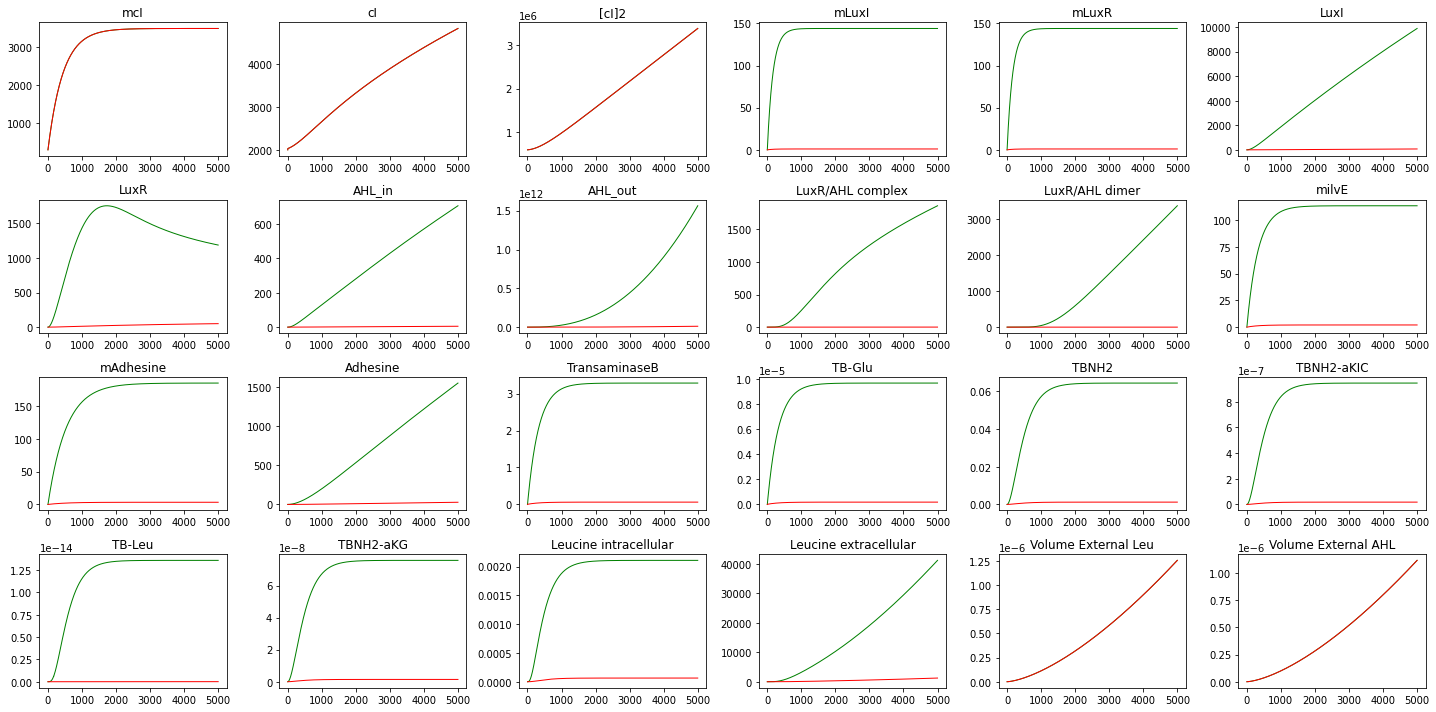

In [34]:
# 初值并未全部给定，故我默认都是0，对一些设为0会导致解方程过程中divide by zero的赋一些极小的值（这里是1e-8）
ini = np.zeros(24)
ini[23] = 5e-18  # 外部体积
ini[22] = 5e-18  # 外部体积
ini[0] = 300  # cI mRNA
ini[1] = 2000 # cI
ini[2] = 6e5  # cI2
ini[10] = 1e-8  # LuxR-AHL 2  防止divide by zero
# 模拟5000个单位
t = np.linspace(1,5000,5000)
# n为on off 开关
para.update({'n_cI':200, 'n_Lux':100})  # off mode
x_off = odeint(dx,ini,t)
para.update({'n_cI':0, 'n_Lux':0})  # on mode
x_on = odeint(dx,ini,t)

titles = ['mcI', 'cI', '[cI]2', 'mLuxI', 'mLuxR', 'LuxI', 'LuxR', 'AHL_in', 'AHL_out', 'LuxR/AHL complex', 'LuxR/AHL dimer', 'milvE', 'mAdhesine', 'Adhesine', 'TransaminaseB', 'TB-Glu', 'TBNH2', 'TBNH2-aKIC', 'TB-Leu', 'TBNH2-aKG', 'Leucine intracellular', 'Leucine extracellular', 'Volume External Leu', 'Volume External AHL']  # 各个子图的title
# 绘图并输出
plt.figure(figsize=(20,10))
for i in range(4):
    for j in range(6):
        count = 6*i + j
        plt.subplot(4,6,count+1)
        plt.plot(t, x_on[:,count], color='green', linewidth=1)
        plt.plot(t, x_off[:,count], color='red', linewidth=1)
        plt.title(titles[count])
plt.tight_layout() 
plt.savefig('./model_wp_hw.jpg')
plt.show()